# Training with Pretrained ResNet Backbones (W&B Integration)

This notebook demonstrates iSAID instance segmentation training using **pretrained ResNet-50/ResNet-101** backbones with FPN from torchvision, instead of our custom EfficientNet + CBAM backbone.

**Features:**

- Uses torchvision's pretrained ResNet-50-FPN or ResNet-101-FPN Mask R-CNN
- Automatic logging of training/validation losses and metrics
- Learning rate scheduling (OneCycleLR or ReduceLROnPlateau)
- Validation predictions visualization
- Model checkpointing as W&B artifacts
- mAP, mean IoU, and overfitting gap metrics


## 1. Setup


In [1]:
!git clone https://github.com/michaelo-ponteski/isaid-instance-segmentation.git

Cloning into 'isaid-instance-segmentation'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 500 (delta 133), reused 142 (delta 72), pack-reused 278 (from 1)
Receiving objects: 100% (500/500), 5.50 MiB | 26.32 MiB/s, done.
Resolving deltas: 100% (261/261), done.


In [2]:
%cd isaid-instance-segmentation
!git pull

/content/isaid-instance-segmentation
Already up to date.


In [3]:
import os
import sys
import gc
import numpy as np
import torch
from pathlib import Path

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

# Set memory optimization for CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB"
    )

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Available memory: 42.5 GB


In [4]:
!pip install --upgrade wandb

In [5]:
# Install wandb if not available
try:
    import wandb
    print(f"wandb version: {wandb.__version__}") # Must be newest
except ImportError:
    print("Installing wandb...")
    !pip install --upgrade wandb
    import wandb

wandb version: 0.24.0


### Kaggle wandb API setup


In [6]:
wandb.login(
    key="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"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: marek-olnk (marek-olnk-put-pozna-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
import importlib
import datasets.isaid_dataset
import training.transforms
import training.trainer

importlib.reload(datasets.isaid_dataset)
importlib.reload(training.transforms)
importlib.reload(training.trainer)

from datasets.isaid_dataset import iSAIDDataset
from training.transforms import get_transforms
from training.trainer import Trainer, create_datasets
from training.wandb_logger import ISAID_CLASS_LABELS

# Import torchvision's pretrained Mask R-CNN models
from torchvision.models.detection import (
    maskrcnn_resnet50_fpn,
    maskrcnn_resnet50_fpn_v2,
    MaskRCNN_ResNet50_FPN_Weights,
    MaskRCNN_ResNet50_FPN_V2_Weights,
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

print("All modules imported successfully!")
print(f"\niSAID Class Labels:")
for idx, name in ISAID_CLASS_LABELS.items():
    print(f"  {idx}: {name}")

All modules imported successfully!

iSAID Class Labels:
  0: background
  1: ship
  2: storage_tank
  3: baseball_diamond
  4: tennis_court
  5: basketball_court
  6: ground_track_field
  7: bridge
  8: large_vehicle
  9: small_vehicle
  10: helicopter
  11: swimming_pool
  12: roundabout
  13: soccer_ball_field
  14: plane
  15: harbor


In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michaeloponteski/isaid-patches")

print("Path to dataset files:", path)

root_dir = path + "/iSAID_patches"
print("Root directory:", root_dir)

100%|██████████| 41.1G/41.1G [04:20<00:00, 169MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/michaeloponteski/isaid-patches/versions/1
Root directory: /root/.cache/kagglehub/datasets/michaeloponteski/isaid-patches/versions/1/iSAID_patches


## 2. Configuration


In [9]:
root_dir = path + "/iSAID_patches"

Hyperparameters:
  data_root: /root/.cache/kagglehub/datasets/michaeloponteski/isaid-patches/versions/1/iSAID_patches
  num_classes: 16
  image_size: 800
  batch_size: 8
  val_batch_size: 16
  num_epochs: 25
  learning_rate: 0.0003
  weight_decay: 0.001
  momentum: 0.9
  backbone: resnet101
  pretrained_backbone: True
  pretrained_coco: True
  anchor_sizes: ((8, 16), (16, 32), (32, 64), (64, 128), (128, 256))
  aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
  wandb_project: isaid-custom-segmentation
  wandb_entity: marek-olnk-put-pozna-
  wandb_log_freq: 20
  wandb_num_val_images: 4
  wandb_conf_threshold: 0.5


In [9]:
# Choose backbone: "resnet50" or "resnet101"
# Note: torchvision provides resnet50_fpn pretrained, for resnet101 we build it manually
BACKBONE_CHOICE = "resnet101"  # Options: "resnet50", "resnet50_v2", "resnet101"

# All hyperparameters in one place - this will be logged to W&B
HYPERPARAMETERS = {
    # Dataset
    "data_root": root_dir,
    "num_classes": 16,
    "image_size": 800,
    # Training
    "batch_size": 8,
    "val_batch_size": 16,
    "num_epochs": 25,
    "learning_rate": 0.0003,
    "weight_decay": 0.001,
    "momentum": 0.9,
    # Model Architecture
    "backbone": BACKBONE_CHOICE,
    "pretrained_backbone": True,
    "pretrained_coco": True,  # Use COCO pretrained weights
    # RPN Anchors (optimized for iSAID)
    "anchor_sizes": ((8, 16), (16, 32), (32, 64), (64, 128), (128, 256)),
    "aspect_ratios": ((0.5, 1.0, 2.0),) * 5,
    # W&B Logging
    "wandb_project": "isaid-resnet50-segmentation",
    "wandb_entity": "marek-olnk-put-pozna-",
    "wandb_log_freq": 20,  # Log every N batches
    "wandb_num_val_images": 4,  # Number of images for validation visualization
    "wandb_conf_threshold": 0.5,  # Confidence threshold for predictions
}

print("Hyperparameters:")
for k, v in HYPERPARAMETERS.items():
    print(f"  {k}: {v}")

Hyperparameters:
  data_root: /root/.cache/kagglehub/datasets/michaeloponteski/isaid-patches/versions/1/iSAID_patches
  num_classes: 16
  image_size: 800
  batch_size: 8
  val_batch_size: 8
  num_epochs: 20
  learning_rate: 0.0003
  weight_decay: 0.001
  momentum: 0.9
  backbone: resnet50
  pretrained_backbone: True
  pretrained_coco: True
  anchor_sizes: ((8, 16), (16, 32), (32, 64), (64, 128), (128, 256))
  aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
  wandb_project: isaid-resnet50-segmentation
  wandb_entity: marek-olnk-put-pozna-
  wandb_log_freq: 20
  wandb_num_val_images: 4
  wandb_conf_threshold: 0.5


## 3. Load Data


In [10]:
# Create datasets
train_dataset, val_dataset = create_datasets(
    data_root=HYPERPARAMETERS["data_root"],
    image_size=HYPERPARAMETERS["image_size"],
    subset_fraction=1.0,  # Use full dataset
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Loading datasets...

DATASET STATISTICS: TRAIN

Image Counts:
   Original images:        28029
   Final images:           26431

Rejected Images (1598 total):
   - Too many boxes (>400): 230
   - Empty image excess:       1368

Box Distribution (final dataset):
   Empty images (0 boxes):  7929 (30.0%)
   Non-empty images:        18502

Box Count Statistics:
   Min:    0
   Max:    400
   Mean:   21.2
   Median: 3.0
   Std:    47.2

   Percentiles:
     25th: 0
     50th: 3
     75th: 18
     90th: 58
     95th: 106
     99th: 262


DATASET STATISTICS: VAL

Image Counts:
   Original images:        9512
   Final images:           8551

Rejected Images (961 total):
   - Too many boxes (>400): 62
   - Empty image excess:       899

Box Distribution (final dataset):
   Empty images (0 boxes):  2565 (30.0%)
   Non-empty images:        5986

Box Count Statistics:
   Min:    0
   Max:    400
   Mean:   22.0
   Median: 3.0
   Std:    48.0

   Percentiles:
     25th: 0
     50th: 3
     75th: 20

## 4. Create Model with Pretrained ResNet Backbone

We use torchvision's pretrained Mask R-CNN models and modify the prediction heads for our number of classes.


In [11]:
def create_maskrcnn_resnet(num_classes, backbone_type="resnet50", pretrained_coco=True):
    """
    Create Mask R-CNN with pretrained ResNet backbone.

    Args:
        num_classes: Number of classes (including background)
        backbone_type: "resnet50", "resnet50_v2", or "resnet101"
        pretrained_coco: Whether to use COCO pretrained weights

    Returns:
        Mask R-CNN model
    """
    if backbone_type == "resnet50":
        # ResNet-50 FPN (original)
        if pretrained_coco:
            weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
            model = maskrcnn_resnet50_fpn(weights=weights)
        else:
            model = maskrcnn_resnet50_fpn(
                weights=None, weights_backbone="IMAGENET1K_V1"
            )

    elif backbone_type == "resnet50_v2":
        # ResNet-50 FPN V2 (improved, better performance)
        if pretrained_coco:
            weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
            model = maskrcnn_resnet50_fpn_v2(weights=weights)
        else:
            model = maskrcnn_resnet50_fpn_v2(
                weights=None, weights_backbone="IMAGENET1K_V1"
            )

    elif backbone_type == "resnet101":
        # ResNet-101 FPN - build manually using backbone_resnet with resnet101
        from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
        from torchvision.models.detection import MaskRCNN
        from torchvision.models import ResNet101_Weights

        # Create ResNet-101 FPN backbone
        backbone = resnet_fpn_backbone(
            backbone_name="resnet101",
            weights=ResNet101_Weights.IMAGENET1K_V1 if pretrained_coco else None,
            trainable_layers=5,  # Train all layers
        )

        # Create Mask R-CNN with ResNet-101 backbone
        model = MaskRCNN(
            backbone,
            num_classes=num_classes,
        )
        return model  # Already has correct num_classes

    else:
        raise ValueError(
            f"Unknown backbone type: {backbone_type}. Use 'resnet50', 'resnet50_v2', or 'resnet101'"
        )

    # For resnet50/resnet50_v2: Replace the pre-trained head with a new one for our num_classes
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the box predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model


# Create model
model = create_maskrcnn_resnet(
    num_classes=HYPERPARAMETERS["num_classes"],
    backbone_type=HYPERPARAMETERS["backbone"],
    pretrained_coco=HYPERPARAMETERS["pretrained_coco"],
)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Backbone: {HYPERPARAMETERS['backbone']}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1e6:.1f} MB (FP32)")

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 229MB/s] 


Backbone: resnet101
Total parameters: 62,937,647
Trainable parameters: 62,937,647
Model size: 251.8 MB (FP32)


## 5. Create Trainer with W&B Integration


In [12]:
# Create trainer with W&B integration
# The trainer handles all logging automatically!
trainer = Trainer(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model=model,
    batch_size=HYPERPARAMETERS["batch_size"],
    val_batch_size=HYPERPARAMETERS["val_batch_size"],
    lr=HYPERPARAMETERS["learning_rate"],
    device=device,
    use_amp=True,
    num_workers=4,
    # W&B configuration
    wandb_project=HYPERPARAMETERS["wandb_project"],
    wandb_entity=HYPERPARAMETERS["wandb_entity"],
    wandb_tags=[
        "maskrcnn",
        HYPERPARAMETERS["backbone"],
        "pretrained",
        "trainer-integrated",
    ],
    wandb_notes=f"Training with {HYPERPARAMETERS['backbone']} backbone (COCO pretrained) + FPN",
    wandb_log_freq=HYPERPARAMETERS["wandb_log_freq"],
    wandb_num_val_images=HYPERPARAMETERS["wandb_num_val_images"],
    wandb_conf_threshold=HYPERPARAMETERS["wandb_conf_threshold"],
    hyperparameters=HYPERPARAMETERS,
)

print(f"\nW&B Run: {trainer.wandb_logger.run.name}")
print(f"URL: {trainer.wandb_logger.run.url}")

Using provided datasets: 26431 train, 8551 val samples
Using provided model
Optimizer parameter groups:
  Base params: 126 tensors, lr=3.00e-04
  RoI params:  20 tensors, lr=7.50e-05 (alpha=0.25)
Device: cuda
AMP enabled: True
Train samples: 26431
Val samples: 8551


W&B run initialized: glorious-monkey-22
View at: https://wandb.ai/marek-olnk-put-pozna-/isaid-custom-segmentation/runs/rkb54dpm
Selected 4 validation images for visualization
W&B logging enabled: https://wandb.ai/marek-olnk-put-pozna-/isaid-custom-segmentation/runs/rkb54dpm

W&B Run: glorious-monkey-22
URL: https://wandb.ai/marek-olnk-put-pozna-/isaid-custom-segmentation/runs/rkb54dpm


## 6. Training

The `Trainer.fit()` method handles everything:

- Training loop with gradient clipping and AMP
- Validation loss computation
- mAP and mean IoU metrics
- W&B logging (losses, gradients, predictions, checkpoints)
- Learning rate scheduling
- Best model saving


In [13]:
# Run training!
# All W&B logging happens automatically inside trainer.fit()
history = trainer.fit(
    epochs=HYPERPARAMETERS["num_epochs"],
    save_dir="checkpoints",
    compute_metrics_every=1,  # Compute mAP every epoch
    max_map_samples=200,  # Limit samples for faster mAP computation
)

print("\nTraining complete!")

Using ReduceLROnPlateau scheduler (steps on validation mAP)

Epoch 1/25 | LR: 3.00e-04


Train Epoch 1:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 1 Results (Time: 1669.5s):
  Losses:
    Train: 1.0509
    Val:   0.8310
  Performance Metrics:
    Train mAP@0.5: 0.2672
    Val mAP@0.5:   0.2340 (primary metric)
    Val Mean IoU:  0.4664
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.165167
    mAP Gap (train-val): +0.0332
  Detailed Train Losses:
    loss_classifier: 0.2334
    loss_box_reg: 0.2025
    loss_mask: 0.3467
    loss_objectness: 0.1507
    loss_rpn_box_reg: 0.1176
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss
-> New best val mAP@0.5: 0.2340
Model checkpoint logged as artifact: isaid-model-best-train-map
-> New best train mAP@0.5: 0.2672

Epoch 2/25 | LR: 3.00e-04


Train Epoch 2:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 2 Results (Time: 1848.1s):
  Losses:
    Train: 0.8247
    Val:   0.7727
  Performance Metrics:
    Train mAP@0.5: 0.4269
    Val mAP@0.5:   0.3717 (primary metric)
    Val Mean IoU:  0.4913
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.040792
    mAP Gap (train-val): +0.0552
  Detailed Train Losses:
    loss_classifier: 0.1679
    loss_box_reg: 0.1836
    loss_mask: 0.2825
    loss_objectness: 0.0986
    loss_rpn_box_reg: 0.0922
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss
-> New best val mAP@0.5: 0.3717
Model checkpoint logged as artifact: isaid-model-best-train-map
-> New best train mAP@0.5: 0.4269

Epoch 3/25 | LR: 3.00e-04


Train Epoch 3:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 3 Results (Time: 1858.5s):
  Losses:
    Train: 0.7614
    Val:   0.7196
  Performance Metrics:
    Train mAP@0.5: 0.4980
    Val mAP@0.5:   0.4516 (primary metric)
    Val Mean IoU:  0.5240
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.033382
    mAP Gap (train-val): +0.0464
  Detailed Train Losses:
    loss_classifier: 0.1492
    loss_box_reg: 0.1742
    loss_mask: 0.2694
    loss_objectness: 0.0845
    loss_rpn_box_reg: 0.0841
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss
-> New best val mAP@0.5: 0.4516
Model checkpoint logged as artifact: isaid-model-best-train-map
-> New best train mAP@0.5: 0.4980

Epoch 4/25 | LR: 3.00e-04


Train Epoch 4:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 4 Results (Time: 1893.8s):
  Losses:
    Train: 0.7229
    Val:   0.6907
  Performance Metrics:
    Train mAP@0.5: 0.5106
    Val mAP@0.5:   0.4431 (primary metric)
    Val Mean IoU:  0.5400
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.031450
    mAP Gap (train-val): +0.0675
  Detailed Train Losses:
    loss_classifier: 0.1384
    loss_box_reg: 0.1673
    loss_mask: 0.2605
    loss_objectness: 0.0770
    loss_rpn_box_reg: 0.0796
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss
-> New best train mAP@0.5: 0.5106

Epoch 5/25 | LR: 3.00e-04


Train Epoch 5:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 5 Results (Time: 1744.9s):
  Losses:
    Train: 0.6974
    Val:   0.6977
  Performance Metrics:
    Train mAP@0.5: 0.6204
    Val mAP@0.5:   0.5545 (primary metric)
    Val Mean IoU:  0.5267
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.038520
    mAP Gap (train-val): +0.0659
  Detailed Train Losses:
    loss_classifier: 0.1311
    loss_box_reg: 0.1624
    loss_mask: 0.2546
    loss_objectness: 0.0727
    loss_rpn_box_reg: 0.0766
-> New best val mAP@0.5: 0.5545
Model checkpoint logged as artifact: isaid-model-best-train-map
-> New best train mAP@0.5: 0.6204

Epoch 6/25 | LR: 3.00e-04


Train Epoch 6:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 6 Results (Time: 1892.1s):
  Losses:
    Train: 0.6758
    Val:   0.7295
  Performance Metrics:
    Train mAP@0.5: 0.5097
    Val mAP@0.5:   0.4781 (primary metric)
    Val Mean IoU:  0.5129
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.028224
    mAP Gap (train-val): +0.0316
  Detailed Train Losses:
    loss_classifier: 0.1249
    loss_box_reg: 0.1583
    loss_mask: 0.2515
    loss_objectness: 0.0673
    loss_rpn_box_reg: 0.0739

Epoch 7/25 | LR: 3.00e-04


Train Epoch 7:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 7 Results (Time: 1831.0s):
  Losses:
    Train: 0.6587
    Val:   0.6679
  Performance Metrics:
    Train mAP@0.5: 0.6667
    Val mAP@0.5:   0.5280 (primary metric)
    Val Mean IoU:  0.5632
  Training Dynamics:
    Gradient Norm: 1.0000
    Loss Variance: 0.026951
    mAP Gap (train-val): +0.1388
  Detailed Train Losses:
    loss_classifier: 0.1205
    loss_box_reg: 0.1553
    loss_mask: 0.2474
    loss_objectness: 0.0634
    loss_rpn_box_reg: 0.0721
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss
-> New best train mAP@0.5: 0.6667

Epoch 8/25 | LR: 3.00e-04


Train Epoch 8:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 8 Results (Time: 1819.7s):
  Losses:
    Train: 0.6470
    Val:   0.6754
  Performance Metrics:
    Train mAP@0.5: 0.6812
    Val mAP@0.5:   0.5179 (primary metric)
    Val Mean IoU:  0.5754
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.025942
    mAP Gap (train-val): +0.1633
  Detailed Train Losses:
    loss_classifier: 0.1171
    loss_box_reg: 0.1534
    loss_mask: 0.2452
    loss_objectness: 0.0606
    loss_rpn_box_reg: 0.0707
-> New best train mAP@0.5: 0.6812

Epoch 9/25 | LR: 3.00e-04


Train Epoch 9:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 9 Results (Time: 1863.9s):
  Losses:
    Train: 0.6388
    Val:   0.7025
  Performance Metrics:
    Train mAP@0.5: 0.6131
    Val mAP@0.5:   0.5090 (primary metric)
    Val Mean IoU:  0.5478
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.026618
    mAP Gap (train-val): +0.1041
  Detailed Train Losses:
    loss_classifier: 0.1143
    loss_box_reg: 0.1510
    loss_mask: 0.2440
    loss_objectness: 0.0598
    loss_rpn_box_reg: 0.0698

Epoch 10/25 | LR: 1.50e-04


Train Epoch 10:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 10 Results (Time: 1778.7s):
  Losses:
    Train: 0.5810
    Val:   0.6610
  Performance Metrics:
    Train mAP@0.5: 0.5959
    Val mAP@0.5:   0.5396 (primary metric)
    Val Mean IoU:  0.5753
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.022112
    mAP Gap (train-val): +0.0563
  Detailed Train Losses:
    loss_classifier: 0.0974
    loss_box_reg: 0.1406
    loss_mask: 0.2346
    loss_objectness: 0.0470
    loss_rpn_box_reg: 0.0614
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss

Epoch 11/25 | LR: 1.50e-04


Train Epoch 11:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 11 Results (Time: 1729.0s):
  Losses:
    Train: 0.5622
    Val:   0.6666
  Performance Metrics:
    Train mAP@0.5: 0.6889
    Val mAP@0.5:   0.5450 (primary metric)
    Val Mean IoU:  0.5721
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.021084
    mAP Gap (train-val): +0.1439
  Detailed Train Losses:
    loss_classifier: 0.0922
    loss_box_reg: 0.1368
    loss_mask: 0.2318
    loss_objectness: 0.0425
    loss_rpn_box_reg: 0.0589
-> New best train mAP@0.5: 0.6889

Epoch 12/25 | LR: 1.50e-04


Train Epoch 12:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 12 Results (Time: 1799.4s):
  Losses:
    Train: 0.5510
    Val:   0.6654
  Performance Metrics:
    Train mAP@0.5: 0.7705
    Val mAP@0.5:   0.5683 (primary metric)
    Val Mean IoU:  0.5758
  Training Dynamics:
    Gradient Norm: 0.9999
    Loss Variance: 0.020878
    mAP Gap (train-val): +0.2022
  Detailed Train Losses:
    loss_classifier: 0.0887
    loss_box_reg: 0.1346
    loss_mask: 0.2299
    loss_objectness: 0.0403
    loss_rpn_box_reg: 0.0576
-> New best val mAP@0.5: 0.5683
Model checkpoint logged as artifact: isaid-model-best-train-map
-> New best train mAP@0.5: 0.7705

Epoch 13/25 | LR: 1.50e-04


Train Epoch 13:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 13 Results (Time: 1960.8s):
  Losses:
    Train: 0.5431
    Val:   0.6899
  Performance Metrics:
    Train mAP@0.5: 0.7197
    Val mAP@0.5:   0.6162 (primary metric)
    Val Mean IoU:  0.5645
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.019617
    mAP Gap (train-val): +0.1034
  Detailed Train Losses:
    loss_classifier: 0.0867
    loss_box_reg: 0.1330
    loss_mask: 0.2285
    loss_objectness: 0.0382
    loss_rpn_box_reg: 0.0568
-> New best val mAP@0.5: 0.6162
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 14/25 | LR: 1.50e-04


Train Epoch 14:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 14 Results (Time: 2140.8s):
  Losses:
    Train: 0.5359
    Val:   0.6610
  Performance Metrics:
    Train mAP@0.5: 0.6904
    Val mAP@0.5:   0.6114 (primary metric)
    Val Mean IoU:  0.5925
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.019822
    mAP Gap (train-val): +0.0790
  Detailed Train Losses:
    loss_classifier: 0.0844
    loss_box_reg: 0.1317
    loss_mask: 0.2274
    loss_objectness: 0.0370
    loss_rpn_box_reg: 0.0554
-> New best model saved (by loss)
Model checkpoint logged as artifact: isaid-model-best-val-loss

Epoch 15/25 | LR: 1.50e-04


Train Epoch 15:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 15 Results (Time: 1994.8s):
  Losses:
    Train: 0.5303
    Val:   0.7166
  Performance Metrics:
    Train mAP@0.5: 0.7329
    Val mAP@0.5:   0.5622 (primary metric)
    Val Mean IoU:  0.5690
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.020457
    mAP Gap (train-val): +0.1707
  Detailed Train Losses:
    loss_classifier: 0.0831
    loss_box_reg: 0.1305
    loss_mask: 0.2255
    loss_objectness: 0.0363
    loss_rpn_box_reg: 0.0549

Epoch 16/25 | LR: 1.50e-04


Train Epoch 16:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 16 Results (Time: 2060.7s):
  Losses:
    Train: 0.5244
    Val:   0.6773
  Performance Metrics:
    Train mAP@0.5: 0.7506
    Val mAP@0.5:   0.5592 (primary metric)
    Val Mean IoU:  0.5838
  Training Dynamics:
    Gradient Norm: 1.0000
    Loss Variance: 0.018891
    mAP Gap (train-val): +0.1914
  Detailed Train Losses:
    loss_classifier: 0.0814
    loss_box_reg: 0.1296
    loss_mask: 0.2245
    loss_objectness: 0.0347
    loss_rpn_box_reg: 0.0541

Epoch 17/25 | LR: 1.50e-04


Train Epoch 17:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 17 Results (Time: 2114.2s):
  Losses:
    Train: 0.5182
    Val:   0.7182
  Performance Metrics:
    Train mAP@0.5: 0.7313
    Val mAP@0.5:   0.6180 (primary metric)
    Val Mean IoU:  0.5661
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.018350
    mAP Gap (train-val): +0.1133
  Detailed Train Losses:
    loss_classifier: 0.0791
    loss_box_reg: 0.1278
    loss_mask: 0.2242
    loss_objectness: 0.0336
    loss_rpn_box_reg: 0.0536
-> New best val mAP@0.5: 0.6180
Model checkpoint logged as artifact: isaid-model-best-train-map

Epoch 18/25 | LR: 1.50e-04


Train Epoch 18:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 18 Results (Time: 2148.5s):
  Losses:
    Train: 0.5132
    Val:   0.6998
  Performance Metrics:
    Train mAP@0.5: 0.7990
    Val mAP@0.5:   0.5794 (primary metric)
    Val Mean IoU:  0.5677
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.026032
    mAP Gap (train-val): +0.2197
  Detailed Train Losses:
    loss_classifier: 0.0786
    loss_box_reg: 0.1267
    loss_mask: 0.2217
    loss_objectness: 0.0334
    loss_rpn_box_reg: 0.0529
-> New best train mAP@0.5: 0.7990

Epoch 19/25 | LR: 1.50e-04


Train Epoch 19:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 19 Results (Time: 2161.0s):
  Losses:
    Train: 0.5104
    Val:   0.6972
  Performance Metrics:
    Train mAP@0.5: 0.7392
    Val mAP@0.5:   0.5798 (primary metric)
    Val Mean IoU:  0.5590
  Training Dynamics:
    Gradient Norm: 1.0000
    Loss Variance: 0.017869
    mAP Gap (train-val): +0.1594
  Detailed Train Losses:
    loss_classifier: 0.0768
    loss_box_reg: 0.1264
    loss_mask: 0.2223
    loss_objectness: 0.0325
    loss_rpn_box_reg: 0.0525

Epoch 20/25 | LR: 1.50e-04


Train Epoch 20:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 20 Results (Time: 2479.5s):
  Losses:
    Train: 0.5066
    Val:   0.6921
  Performance Metrics:
    Train mAP@0.5: 0.8124
    Val mAP@0.5:   0.5506 (primary metric)
    Val Mean IoU:  0.5645
  Training Dynamics:
    Gradient Norm: 1.0000
    Loss Variance: 0.017860
    mAP Gap (train-val): +0.2618
  Detailed Train Losses:
    loss_classifier: 0.0757
    loss_box_reg: 0.1259
    loss_mask: 0.2215
    loss_objectness: 0.0315
    loss_rpn_box_reg: 0.0520
-> New best train mAP@0.5: 0.8124

Epoch 21/25 | LR: 1.50e-04


Train Epoch 21:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 21 Results (Time: 2458.7s):
  Losses:
    Train: 0.5019
    Val:   0.6695
  Performance Metrics:
    Train mAP@0.5: 0.7691
    Val mAP@0.5:   0.5577 (primary metric)
    Val Mean IoU:  0.5952
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.017925
    mAP Gap (train-val): +0.2114
  Detailed Train Losses:
    loss_classifier: 0.0743
    loss_box_reg: 0.1243
    loss_mask: 0.2200
    loss_objectness: 0.0315
    loss_rpn_box_reg: 0.0518

Epoch 22/25 | LR: 7.50e-05


Train Epoch 22:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 22 Results (Time: 2453.0s):
  Losses:
    Train: 0.4712
    Val:   0.7120
  Performance Metrics:
    Train mAP@0.5: 0.8274
    Val mAP@0.5:   0.5323 (primary metric)
    Val Mean IoU:  0.5798
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.016106
    mAP Gap (train-val): +0.2951
  Detailed Train Losses:
    loss_classifier: 0.0654
    loss_box_reg: 0.1174
    loss_mask: 0.2152
    loss_objectness: 0.0258
    loss_rpn_box_reg: 0.0475
-> New best train mAP@0.5: 0.8274

Epoch 23/25 | LR: 7.50e-05


Train Epoch 23:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 23 Results (Time: 2728.3s):
  Losses:
    Train: 0.4595
    Val:   0.7173
  Performance Metrics:
    Train mAP@0.5: 0.8234
    Val mAP@0.5:   0.5623 (primary metric)
    Val Mean IoU:  0.5843
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.016115
    mAP Gap (train-val): +0.2611
  Detailed Train Losses:
    loss_classifier: 0.0623
    loss_box_reg: 0.1146
    loss_mask: 0.2126
    loss_objectness: 0.0241
    loss_rpn_box_reg: 0.0459

Epoch 24/25 | LR: 7.50e-05


Train Epoch 24:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 24 Results (Time: 2604.8s):
  Losses:
    Train: 0.4547
    Val:   0.7275
  Performance Metrics:
    Train mAP@0.5: 0.8451
    Val mAP@0.5:   0.5762 (primary metric)
    Val Mean IoU:  0.5850
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.017191
    mAP Gap (train-val): +0.2689
  Detailed Train Losses:
    loss_classifier: 0.0609
    loss_box_reg: 0.1132
    loss_mask: 0.2116
    loss_objectness: 0.0239
    loss_rpn_box_reg: 0.0451
-> New best train mAP@0.5: 0.8451

Epoch 25/25 | LR: 7.50e-05


Train Epoch 25:   0%|          | 0/3303 [00:00<?, ?it/s]

Validation:   0%|          | 0/535 [00:00<?, ?it/s]

Computing mAP metrics...

Epoch 25 Results (Time: 2705.0s):
  Losses:
    Train: 0.4520
    Val:   0.7639
  Performance Metrics:
    Train mAP@0.5: 0.7688
    Val mAP@0.5:   0.5590 (primary metric)
    Val Mean IoU:  0.5819
  Training Dynamics:
    Gradient Norm: nan
    Loss Variance: 0.054426
    mAP Gap (train-val): +0.2098
  Detailed Train Losses:
    loss_classifier: 0.0596
    loss_box_reg: 0.1118
    loss_mask: 0.2107
    loss_objectness: 0.0253
    loss_rpn_box_reg: 0.0447

Training complete!
  Best val loss: 0.6610
  Best val mAP@0.5: 0.6180

Training complete!


In [14]:
# Create artifact for the final trained model
artifact = wandb.Artifact(
    name=f"isaid-maskrcnn-{HYPERPARAMETERS['backbone']}-final",
    type="model",
    description=f"Final trained Mask R-CNN ({HYPERPARAMETERS['backbone']}) after {HYPERPARAMETERS['num_epochs']} epochs",
    metadata={
        "backbone": HYPERPARAMETERS["backbone"],
        "num_classes": HYPERPARAMETERS["num_classes"],
        "pretrained_coco": HYPERPARAMETERS["pretrained_coco"],
        "final_train_loss": history["train/loss"][-1],
        "final_val_loss": history["val/loss"][-1],
        "final_val_mAP": history["val/mAP@0.5"][-1],
        "best_val_mAP": max(history["val/mAP@0.5"]),
    }
)

# Add model checkpoint files
artifact.add_file("checkpoints/best.pth", name="best_model.pth")
artifact.add_file("checkpoints/best_map.pth", name="best_map_model.pth")
artifact.add_file("checkpoints/last.pth", name="last_model.pth")

# Log the artifact
trainer.wandb_logger.run.log_artifact(artifact)

print(f"Model artifacts saved to W&B!")
print(f"  - best_model.pth (lowest val loss)")
print(f"  - best_map_model.pth (highest val mAP)")
print(f"  - last_model.pth (final epoch)")

Model artifacts saved to W&B!
  - best_model.pth (lowest val loss)
  - best_map_model.pth (highest val mAP)
  - last_model.pth (final epoch)


## 7. Visualize Results


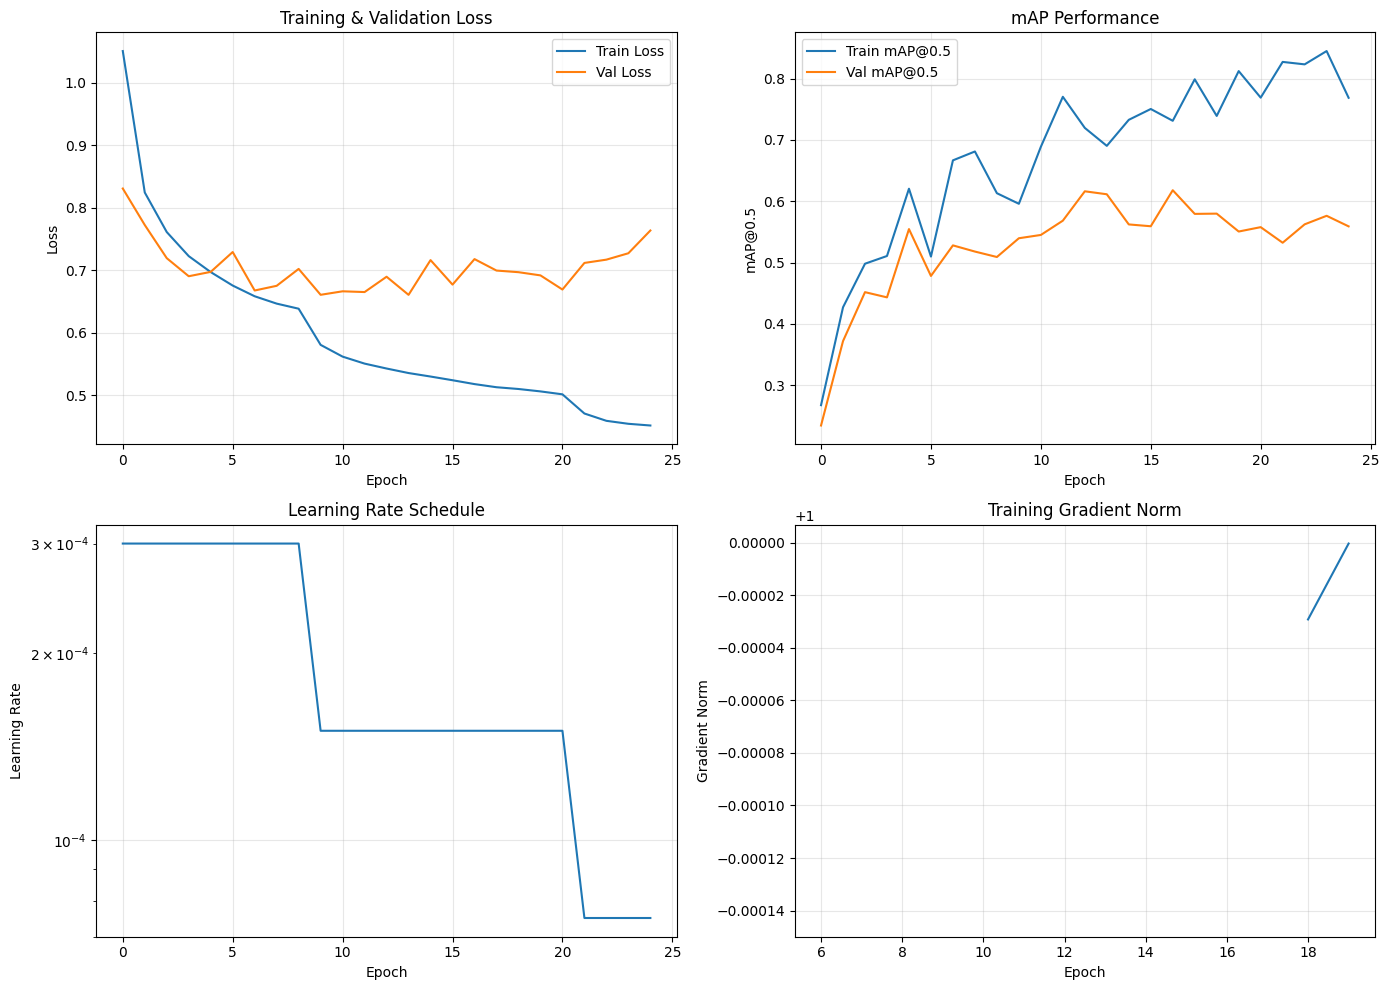

In [15]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
ax = axes[0, 0]
ax.plot(history["train/loss"], label="Train Loss")
ax.plot(history["val/loss"], label="Val Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training & Validation Loss")
ax.legend()
ax.grid(True, alpha=0.3)

# mAP curves
ax = axes[0, 1]
ax.plot(history["train/mAP@0.5"], label="Train mAP@0.5")
ax.plot(history["val/mAP@0.5"], label="Val mAP@0.5")
ax.set_xlabel("Epoch")
ax.set_ylabel("mAP@0.5")
ax.set_title("mAP Performance")
ax.legend()
ax.grid(True, alpha=0.3)

# Learning rate
ax = axes[1, 0]
ax.plot(history["train/lr"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.set_title("Learning Rate Schedule")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

# Gradient norm
ax = axes[1, 1]
ax.plot(history["train/grad_norm"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Gradient Norm")
ax.set_title("Training Gradient Norm")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Visualize Predictions


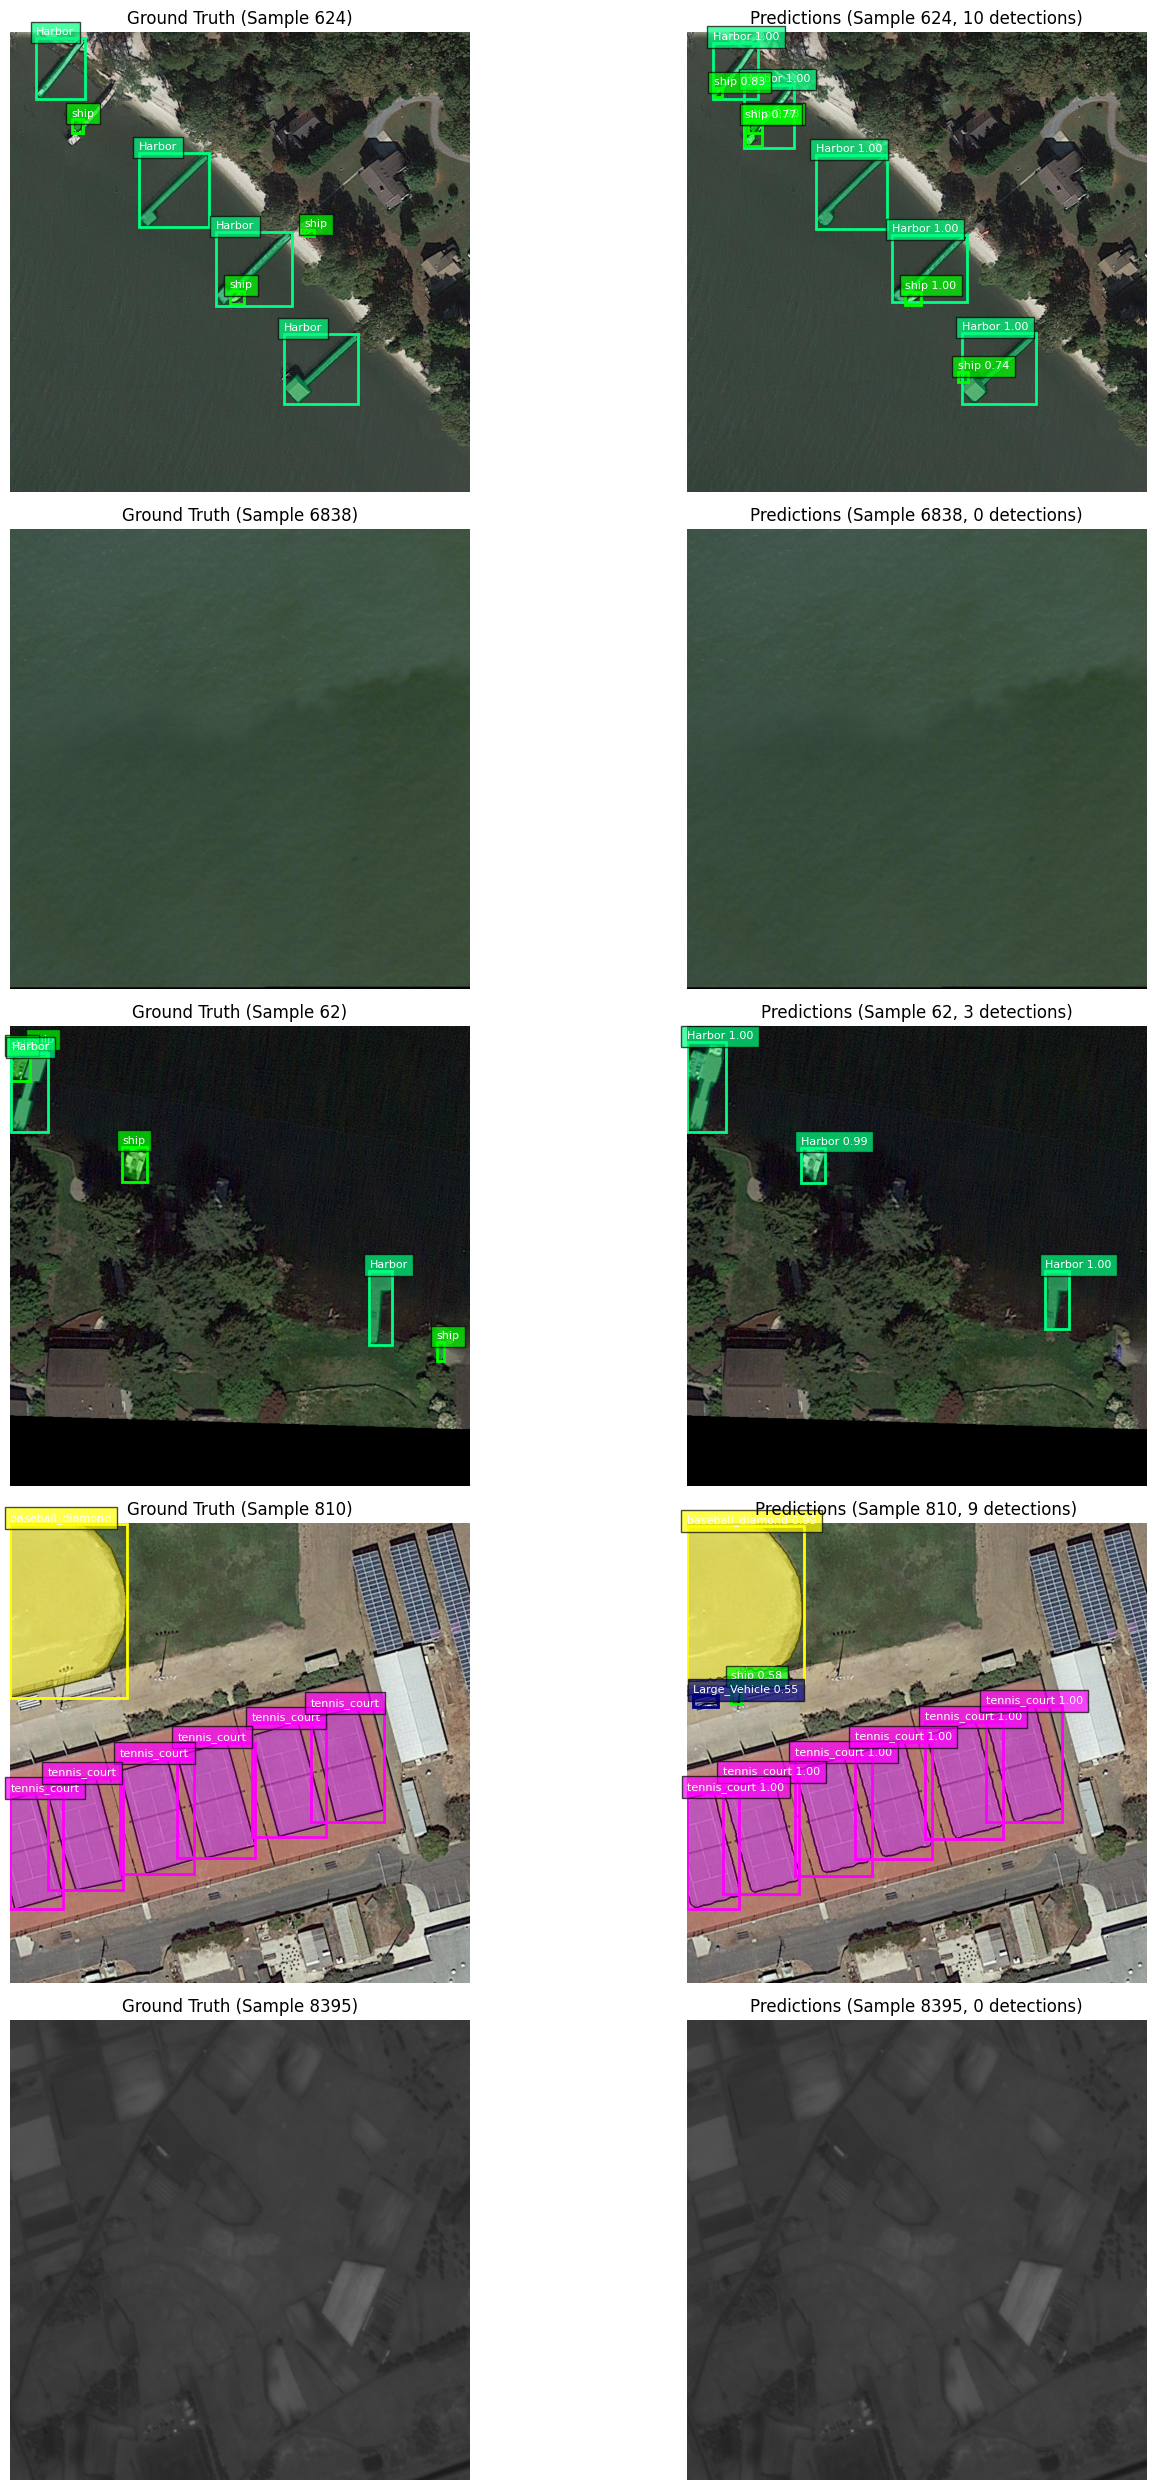

In [16]:
# Visualize predictions on validation set
trainer.visualize_predictions(
    num_samples=5,
    score_threshold=0.5,
    mask_alpha=0.4,
)

## 9. Finish W&B Run


In [17]:
# Finish the W&B run
trainer.finish()

print(f"\nW&B run completed!")
print(f"View results at: {trainer.wandb_logger.run.url}")

grads/backbone_norm,▄▃▃▁▅▆▄▃▅▄▃▁▆ ▄▇▆▄▅▅▆▆▆▅▁▆▇▅▆▄▁▇▃▆█▄▇▆▅▃
grads/roi_head_mean,█▇▄▅▇▆▆▅▂▂▅▂▃▄▅▃▂▂▃▄▂▅▄▂▃▃▃▁▃▃▂▃▃▂▄▁▁▄▂▃
grads/roi_head_norm,▇█▂▅▆▇▇▇▄▅▅▄▆▄▅▄▇▅▄▆▄▅▆▃▆▅▁▄▄▇▃▇▂▅▆▅▆▅▅▅
grads/total_norm,▆▇▇█▆▃▄▃▄▇▆▄▃▃▃▃▁▃▃▃▆▂▃▄▃▆▆▄▆▃▅▆▃▅▂█▃▃▃▅
train/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train/learning_rate,███████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
train/mask_loss,▇▅▄▄▅█▄▄▁▃▃▃▄▅▅▄▃▅▅▂▅▂▄▂▅▃▅▆▄▂▃▃▃▃▃▁▂▁▃▃
train/roi_box_loss,▄▅█▅▃▃▆▃▃▄▁▄▅▃▄▃▃▅▄▄▂▃▄▁▂▄▃▁▁▂▆▃▂▃▃▁▂▄▃▅
train/roi_class_loss,▅▇▇▄▇▅▃█▄▅▄▃▄▄▄▃▂▃▂▂▂▃▃▆▃▃▃▃▄▂▄▂▂▄▅▂▃▂▂▁
train/rpn_box_loss,▄▃▃▇▂▃▃▃▃█▂▂▂▄▃▂▃▂▂▁▂▁▂▃▃▂▃▂▂▄▃▂▂▁▃▁▂▃▃▂
+9,...


W&B run finished.
W&B run finished.

W&B run completed!
View results at: https://wandb.ai/marek-olnk-put-pozna-/isaid-custom-segmentation/runs/rkb54dpm


## 10. Load Model from W&B Artifact (Optional)


In [18]:
# Example: Load best model from W&B artifacts
# Uncomment to use

# import wandb
# api = wandb.Api()
# artifact = api.artifact('YOUR_ENTITY/isaid-resnet-segmentation/isaid-model:best')
# artifact_dir = artifact.download()
#
# # Recreate model with same architecture
# model = create_maskrcnn_resnet(num_classes=16, backbone_type="resnet50")
# model.load_state_dict(torch.load(f"{artifact_dir}/best_model.pth"))
# model.eval()
# print("Model loaded from W&B artifact!")